# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [2]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)

def linear_kernel_value(u, v):
    return np.dot(u, v)

def poly_kernel_value(u, v, d):
    return (1+np.dot(u, v))**d

def rbf_kernel_value(u, v, gamma):
    return np.exp(-1*gamma*(np.dot(np.subtract(u, v), np.subtract(u, v))))

def get_kernel_value(u, v, kernel, kernel_param):
    if kernel == 'linear':
        return linear_kernel_value(u, v)
    elif kernel == 'rbf':
        return rbf_kernel_value(u, v, kernel_param)
    elif kernel == 'poly':
        return poly_kernel_value(u, v, kernel_param)

def get_kernel_values_old(u, V, kernel, kernel_param):
    if kernel == 'rbf':
        return np.exp(-1*kernel_param*(
            np.add(np.matmul(u.T, u), 
            np.add(-2*np.matmul(u.T, V), np.sum(V**2, axis=0)))
        ))
    else:
        return get_kernel_value(u, V, kernel, kernel_param)

def get_kernel_values(X, Y, kernel, kernel_param):
    """
    Arguments:
    X : (n,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly'
    reg_param = lambda, for regularized logistic regression
    kernel_param = gamma for rbf kernel or degree of poly kernel

    Returns the kernel matrix :
    K: (n,n) shape numpy array
    """
    if kernel == 'linear':
        return np.matmul(X, np.transpose(Y))
    elif kernel == 'poly':
        return (1 + np.matmul(X, np.transpose(Y)))**kernel_param
    elif kernel == 'rbf':
        X_norm_sq = np.sum(X**2, axis=-1)
        Y_norm_sq = np.sum(Y**2, axis=-1)
        return np.exp(-1 * kernel_param * (X_norm_sq[:, None] + Y_norm_sq[None, :] - 2*np.matmul(X, np.transpose(Y))))

def get_kernel_matrix(X, kernel, kernel_param):
    """
    Arguments:
    X : (n,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly'
    reg_param = lambda, for regularized logistic regression
    kernel_param = gamma for rbf kernel or degree of poly kernel

    Returns the kernel matrix :
    K: (n,n) shape numpy array
    """
    return get_kernel_values(X, X, kernel, kernel_param)

def compute_gradient(K, Y, reg_param, alpha):
    grad = reg_param * np.matmul(K, alpha)
    for i in range(Y.shape[0]):
        grad = np.add(grad, (-1*Y[i]/(1+np.exp(Y[i]*np.dot(alpha, K[:, i]))))*K[:, i])
    return grad

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=100):
    """
    Arguments:
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = $\ lambda$
    num_iter_gd = number of GD iterations.

    Returns the result of kernel logistic regression :
    alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    Primal problem:
    $ \ min_w  \ sum_{i=1}^n \ log(1+\exp(-y_i* \ w^\ top \ phi(\ x_i)))  + \ frac{\ lambda}{2} ||\ w||^2 $

    the dual of which is

    $ \ min_alpha \ sum_{i=1}^n \ log(1+\exp(-y_i* \ alpha^\ top K_{:,i} ))  + \ frac{\ lambda}{2} \ alpha^\ top K \ alpha $
    where $\ phi$ is the feature got by the kernel.

    Where K is the nxn kernel matrix computed on the training data.

    The kernel is defined by the kernel_param:
    If kernel=linear: K(\ u,\ v) = \ u^\ top \ v  
    If kernel=poly:  K(\ u,\ v) = (1+\ u^\ top \ v)^(kernel_param)
    If kernel=rbf:  K(\ u,\ v) = \ exp(-kernel_param*||\ u-\ v||^2)
    """
    n = Y.shape[0]
    K = get_kernel_matrix(X, kernel, kernel_param)
    # Initialization
    learning_rate = 0.1 
    alpha = np.zeros(shape=(n,))
    for iteration in range(num_iter_gd):
        alpha = np.subtract(alpha, learning_rate * compute_gradient(K, Y, reg_param, alpha))
    return alpha


def get_pred(alpha, kernel_values):
    res = np.matmul(kernel_values, alpha)
    for i in range(res.shape[0]):
        if res[i] < 0:
            res[i] = -1
        else:
            res[i] = 1
    return res

def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    return get_pred(alpha, get_kernel_values(test_X, train_X, kernel, kernel_param))


In [3]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

# RUNS FOR AROUND 12 MINUTES

def cross_validate(X, Y, kernel):
    """
    Arguments:
    X : Training data X_train, numpy array of shape (n,d)
    Y : Training labels Y_train, numpy array of shape (n,)
    kernel = choice of kernel, 'linear', 'rbf' or 'poly'

    Returns a tuple (best_reg_param, best_kernel_param), choosing the best hyperparameters by performing cross-validation
    """
    n = X.shape[0]
    X_train = X[:int(0.8*n)]
    X_val = X[int(0.8*n):]
    Y_train = Y[:int(0.8*n)]
    Y_val = Y[int(0.8*n):]

    reg_params = np.logspace(-4, 1, num=6, base=10)
    kernel_params = np.array([0])
    if kernel == 'rbf':
        kernel_params = np.logspace(-4, 1, num=6, base=10)
    elif kernel == 'poly':
        kernel_params = np.logspace(0, 3, num=4, base=2)
    accuracies = np.zeros(shape=(np.size(reg_params), np.size(kernel_params)))
    for i,reg_param in enumerate(reg_params):
        for j,kernel_param in enumerate(kernel_params):
            alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
            accuracies[i, j] = accuracy_score(Y_val, test_pred(alpha, X_train, Y_train, X_val, kernel, kernel_param))
    best_hyperparams = np.argmax(accuracies)
    best_reg_param = reg_params[best_hyperparams // np.size(kernel_params)]
    best_kernel_param = kernel_params[best_hyperparams % np.size(kernel_params)]
    return (best_reg_param, best_kernel_param)

files = ["dataset_A", "dataset_B", "dataset_C", "dataset_D"]
kernels = ['linear', 'rbf', 'poly']
best_alphas = np.zeros((4,3)).tolist()
for i,file in enumerate(files):
    dataset = np.load("../../Data/" + file + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    print(file)
    for j,kernel in enumerate(kernels):
        print("Kernel: " + kernel)
        reg_param, kernel_param = cross_validate(X_train, Y_train, kernel)
        print("Best lambda:" + str(reg_param))
        if kernel == 'rbf':
            print("Best gamma: " + str(kernel_param))
        elif kernel == 'poly':
            print("Best degree: " + str(kernel_param))
        alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
        best_alphas[i][j] = alpha
        train_error = 1 - accuracy_score(Y_train, test_pred(alpha, X_train, Y_train, X_train, kernel, kernel_param))
        print("Train zero-one error: " + str(train_error))
        test_error = 1 - accuracy_score(Y_test, test_pred(alpha, X_train, Y_train, X_test, kernel, kernel_param))
        print("Test zero-one error: " + str(test_error))


dataset_A
Kernel: linear


/tmp/ipykernel_72684/1285911145.py:70: RuntimeWarning: overflow encountered in exp
  grad = np.add(grad, (-1*Y[i]/(1+np.exp(Y[i]*np.dot(alpha, K[:, i]))))*K[:, i])
/tmp/ipykernel_72684/1285911145.py:68: RuntimeWarning: overflow encountered in multiply
  grad = reg_param * np.matmul(K, alpha)
/tmp/ipykernel_72684/1285911145.py:113: RuntimeWarning: overflow encountered in matmul
  res = np.matmul(kernel_values, alpha)
/tmp/ipykernel_72684/1285911145.py:113: RuntimeWarning: invalid value encountered in matmul
  res = np.matmul(kernel_values, alpha)


Best lambda:0.0001
Train zero-one error: 0.17200000000000004
Test zero-one error: 0.15800000000000003
Kernel: rbf
Best lambda:0.0001
Best gamma: 1.0
Train zero-one error: 0.0020000000000000018
Test zero-one error: 0.006000000000000005
Kernel: poly


/tmp/ipykernel_72684/1285911145.py:68: RuntimeWarning: overflow encountered in matmul
  grad = reg_param * np.matmul(K, alpha)
/tmp/ipykernel_72684/1285911145.py:108: RuntimeWarning: invalid value encountered in subtract
  alpha = np.subtract(alpha, learning_rate * compute_gradient(K, Y, reg_param, alpha))
/tmp/ipykernel_72684/1285911145.py:68: RuntimeWarning: invalid value encountered in matmul
  grad = reg_param * np.matmul(K, alpha)


Best lambda:0.0001
Best degree: 2.0
Train zero-one error: 0.1306666666666667
Test zero-one error: 0.15600000000000003
dataset_B
Kernel: linear
Best lambda:0.0001
Train zero-one error: 0.2513333333333333
Test zero-one error: 0.23399999999999999
Kernel: rbf
Best lambda:0.001
Best gamma: 0.01
Train zero-one error: 0.5286666666666666
Test zero-one error: 0.51
Kernel: poly
Best lambda:0.0001
Best degree: 4.0
Train zero-one error: 0.17600000000000005
Test zero-one error: 0.19399999999999995
dataset_C
Kernel: linear
Best lambda:0.0001
Train zero-one error: 0.4973333333333333
Test zero-one error: 0.4882154882154882
Kernel: rbf
Best lambda:0.0001
Best gamma: 0.1
Train zero-one error: 0.0
Test zero-one error: 0.030303030303030276
Kernel: poly
Best lambda:0.0001
Best degree: 1.0
Train zero-one error: 0.4973333333333333
Test zero-one error: 0.4882154882154882
dataset_D
Kernel: linear
Best lambda:0.0001
Train zero-one error: 0.4325
Test zero-one error: 0.23076923076923073
Kernel: rbf
Best lambda:0.

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

### Observations:

RBF seems to be the best choice of kernel, except in dataset B, where it could be the case that the range of hyperparameters doesn't cover the best choice. Dataset A is separated well, while datasets B and D are separated decently well. Dataset C shows a stark contrast between polynomials and rbf, suggesting it might be a high-degree polynomial.

### Cross-validation information:

#### dataset_A

| Kernel\Info | Best lambda | Best kernel_param | Train error | Test error |
| :---------: | :---------: | :---------------: | :---------: | :--------: |
| linear      | 0.0001      | N/A               | 0.172       | 0.158      |
| rbf         | 0.0001      | 1                 | 0.002       | 0.006      |
| poly        | 0.0001      | 2                 | 0.130667    | 0.156      |

#### dataset_B

| Kernel\Info | Best lambda | Best kernel_param | Train error | Test error |
| :---------: | :---------: | :---------------: | :---------: | :--------: |
| linear      | 0.0001      | N/A               | 0.251333    | 0.234      |
| rbf         | 0.001       | 0.01              | 0.528667    | 0.51       |
| poly        | 0.0001      | 4                 | 0.176       | 0.194      |

#### dataset_C

| Kernel\Info | Best lambda | Best kernel_param | Train error | Test error |
| :---------: | :---------: | :---------------: | :---------: | :--------: |
| linear      | 0.0001      | N/A               | 0.497333    | 0.488215   |
| rbf         | 0.0001      | 0.1               | 0           | 0.030303   |
| poly        | 0.0001      | 1                 | 0.497333    | 0.488215   |

#### dataset_D

| Kernel\Info | Best lambda | Best kernel_param | Train error | Test error |
| :---------: | :---------: | :---------------: | :---------: | :--------: |
| linear      | 0.0001      | N/A               | 0.4325      | 0.230769   |
| rbf         | 0.0001      | 0.0001            | 0.08        | 0.147929   |
| poly        | 0.0001      | 1                 | 0.4325      | 0.230769   |


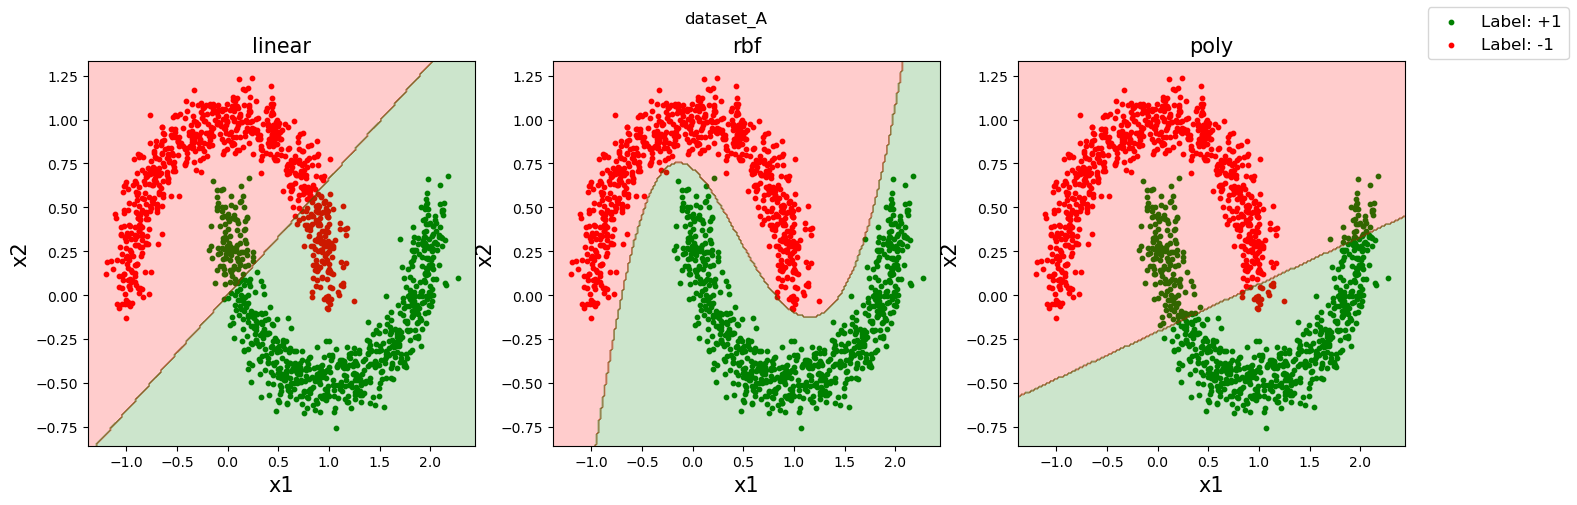

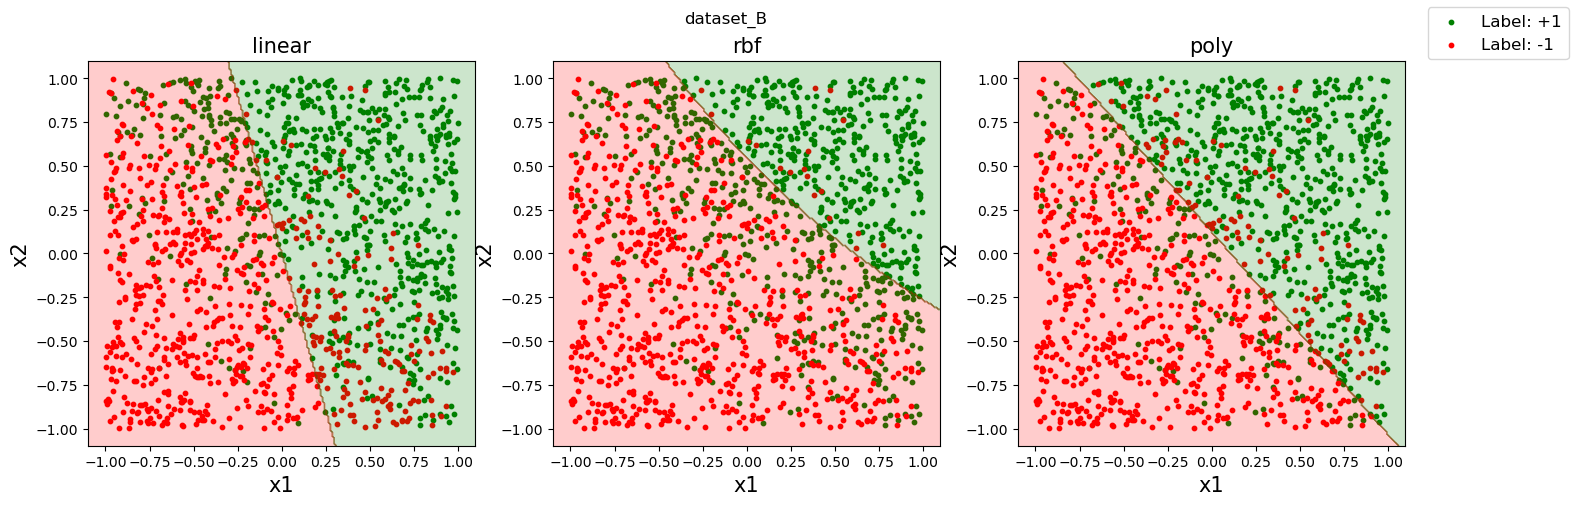

In [4]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

filenames = ['dataset_A', 'dataset_B']
kernels = ['linear', 'rbf', 'poly']
for j,filename in enumerate(filenames):
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
    line = [0, 0]
    for i,kernel in enumerate(kernels):
        alpha = best_alphas[j][i]
        X_train_plus = X_train[Y_train==1]
        X_train_minus = X_train[Y_train==-1]
        line[0] = ax[i].scatter(X_train_plus[:,0], X_train_plus[:,1], c="green", s=10)
        line[1] = ax[i].scatter(X_train_minus[:,0], X_train_minus[:,1], c="red", s=10)
        x_min, x_max = ax[i].get_xlim()
        y_min, y_max = ax[i].get_ylim()
        X,Y = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
        X_bg = np.transpose(np.array([np.ndarray.flatten(X), np.ndarray.flatten(Y)]))
        Z = test_pred(alpha, X_train, Y_train, X_bg, kernel, kernel_param)
        Z = np.reshape(a=Z, newshape=X.shape, order='C')
        ax[i].contourf(X, Y, Z, colors=["red", "green"], alpha=0.2)
        ax[i].set_xlabel("x1", fontsize=15)
        ax[i].set_ylabel("x2", fontsize=15)
        ax[i].set_title(kernel, fontsize=15)
    plt.suptitle(filename)
    fig.legend(handles=line, labels=["Label: +1", "Label: -1"], fontsize=12)
    plt.show()


# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [5]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

def learn_SVM(X, Y, kernel='linear', reg_param=0., kernel_param=1.):
    """
    Makes an svm.SVC object, fits it to X, Y, and returns the object
    """
    svm_clf = svm.SVC(C=reg_param, kernel=kernel, coef0=1)
    if kernel == 'rbf':
        svm_clf.set_params(**{'gamma':kernel_param})
    elif kernel == 'poly':
        svm_clf.set_params(**{'degree':kernel_param, 'gamma':1})
    svm_clf.fit(X, Y)
    return svm_clf


In [6]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.

# RUNS FOR ABOUT 1.5 MINUTES

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)

class CustomScaler:
    def __init__(self, low, high):
        self.low = low
        self.high = high
    
    def scale(self, x):
        return (x - self.low)/(self.high - self.low)

    def rescale(self, x):
        return self.low + x * (self.high - self.low)


def cross_validate(X, Y, kernel):
    """
    Arguments:
    X : Training data X_train, numpy array of shape (n,d)
    Y : Training labels Y_train, numpy array of shape (n,)
    kernel = choice of kernel, 'linear', 'rbf' or 'poly'

    Returns a tuple (best_reg_param, best_kernel_param), choosing the best hyperparameters by performing cross-validation
    """
    n = X.shape[0]
    X_train = X[:int(0.8*n)]
    X_val = X[int(0.8*n):]
    Y_train = Y[:int(0.8*n)]
    Y_val = Y[int(0.8*n):]

    reg_params = np.logspace(-4, 1, num=6, base=10)
    kernel_params = np.array([0])
    if kernel == 'rbf':
        kernel_params = np.logspace(-4, 1, num=6, base=10)
    elif kernel == 'poly':
        kernel_params = np.logspace(0, 4, num=5, base=2)
    accuracies = np.zeros(shape=(np.size(reg_params), np.size(kernel_params)))
    for i,reg_param in enumerate(reg_params):
        for j,kernel_param in enumerate(kernel_params):
            svm_clf = learn_SVM(X_train, Y_train, kernel, reg_param, kernel_param)
            accuracies[i, j] = accuracy_score(Y_val, svm_clf.predict(X_val))
    best_hyperparams = np.argmax(accuracies)
    best_reg_param = reg_params[best_hyperparams // np.size(kernel_params)]
    best_kernel_param = kernel_params[best_hyperparams % np.size(kernel_params)]
    return (best_reg_param, best_kernel_param)

files = ["dataset_A", "dataset_B", "dataset_C", "dataset_D"]
kernels = ['linear', 'rbf', 'poly']
best_svcs = np.zeros((4,3)).tolist()
for i,file in enumerate(files):
    dataset = np.load("../../Data/" + file + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    scaler = CustomScaler(np.min(X_train), np.max(X_train))
    X_train = scaler.scale(X_train)
    X_test = scaler.scale(X_test)
    print(file)
    for j,kernel in enumerate(kernels):
        print("Kernel: " + kernel)
        reg_param, kernel_param = cross_validate(X_train, Y_train, kernel)
        print("Best C:" + str(reg_param))
        if kernel == 'rbf':
            print("Best gamma: " + str(kernel_param))
        elif kernel == 'poly':
            print("Best degree: " + str(kernel_param))
        svm_clf = learn_SVM(X_train, Y_train, kernel, reg_param, kernel_param)
        best_svcs[i][j] = svm_clf
        train_error = 1 - accuracy_score(Y_train, svm_clf.predict(X_train))
        print("Train zero-one error: " + str(train_error))
        test_error = 1 - accuracy_score(Y_test, svm_clf.predict(X_test))
        print("Test zero-one error: " + str(test_error))

dataset_A
Kernel: linear
Best C:10.0
Train zero-one error: 0.1293333333333333
Test zero-one error: 0.134
Kernel: rbf
Best C:1.0
Best gamma: 10.0
Train zero-one error: 0.0013333333333332975
Test zero-one error: 0.0020000000000000018
Kernel: poly
Best C:0.01
Best degree: 16.0
Train zero-one error: 0.0013333333333332975
Test zero-one error: 0.008000000000000007
dataset_B
Kernel: linear
Best C:1.0
Train zero-one error: 0.17733333333333334
Test zero-one error: 0.20399999999999996
Kernel: rbf
Best C:1.0
Best gamma: 0.1
Train zero-one error: 0.17533333333333334
Test zero-one error: 0.19599999999999995
Kernel: poly
Best C:0.001
Best degree: 4.0
Train zero-one error: 0.18333333333333335
Test zero-one error: 0.21799999999999997
dataset_C
Kernel: linear
Best C:0.1
Train zero-one error: 0.07466666666666666
Test zero-one error: 0.09427609427609429
Kernel: rbf
Best C:1.0
Best gamma: 1.0
Train zero-one error: 0.0
Test zero-one error: 0.030303030303030276
Kernel: poly
Best C:0.001
Best degree: 4.0
Tra

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

### Observations:

RBF kernel has the best accuracy for all datasets, due to its feature vector allowing for high-degree fits. Dataset A is easy to separate, but not with a 2d line, so RBF and poly fit very well, much better than linear. Dataset B is virtually impossible to separate, so all kernels achieve an accuracy of only nearly 80%. Dataset C appears to be a clean polynomial of degree > 1, as poly and rbf have the same result of 97% accuracy, which is better than linear. Dataset D is very consistent across kernels, all of them fitting with ~95% accuracy.

### Cross-validation information:

#### dataset_A

| Kernel\Info   | Best C | Best kernel parameter | Train error | Test error |
| :-----------: | :----: | :-------------------: | :---------: | :--------: |
| <b>linear</b> | 10     | N/A                   | 0.129333    | 0.134      |
| <b>rbf</b>    | 1      | 10                    | 0.001333    | 0.002      |
| <b>poly</b>   | 0.01   | 16                    | 0.001333    | 0.008      |

#### dataset_B

| Kernel\Info   | Best C | Best kernel parameter | Train error | Test error |
| :-----------: | :----: | :-------------------: | :---------: | :--------: |
| <b>linear</b> | 1      | N/A                   | 0.177333    | 0.204      |
| <b>rbf</b>    | 1      | 0.1                   | 0.175333    | 0.196      |
| <b>poly</b>   | 0.001  | 4                     | 0.183333    | 0.218      |

#### dataset_C

| Kernel\Info   | Best C | Best kernel parameter | Train error | Test error |
| :-----------: | :----: | :-------------------: | :---------: | :--------: |
| <b>linear</b> | 0.1    | N/A                   | 0.074667    | 0.094276   |
| <b>rbf</b>    | 1      | 1                     | 0           | 0.030303   |
| <b>poly</b>   | 0.001  | 4                     | 0           | 0.030303   |

#### dataset_D

| Kernel\Info   | Best C | Best kernel parameter | Train error | Test error |
| :-----------: | :----: | :-------------------: | :---------: | :--------: |
| <b>linear</b> | 1      | N/A                   | 0.12        | 0.065089   |
| <b>rbf</b>    | 10     | 0.1                   | 0.105       | 0.047337   |
| <b>poly</b>   | 1      | 1                     | 0.12        | 0.065089   |

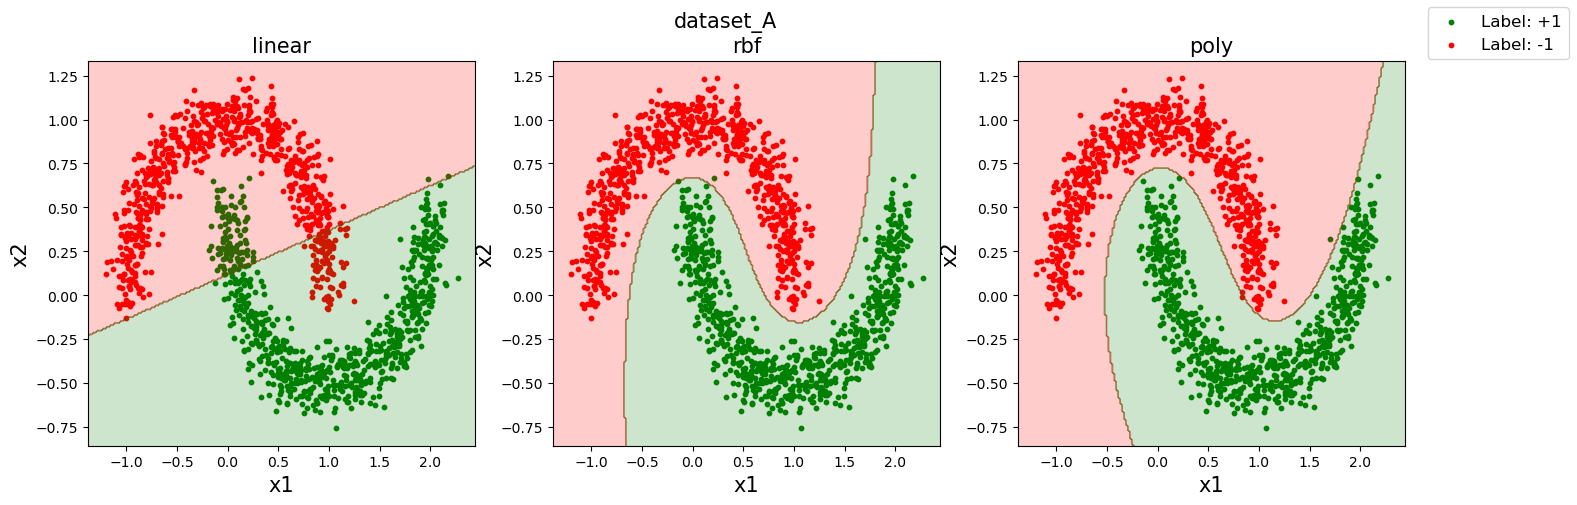

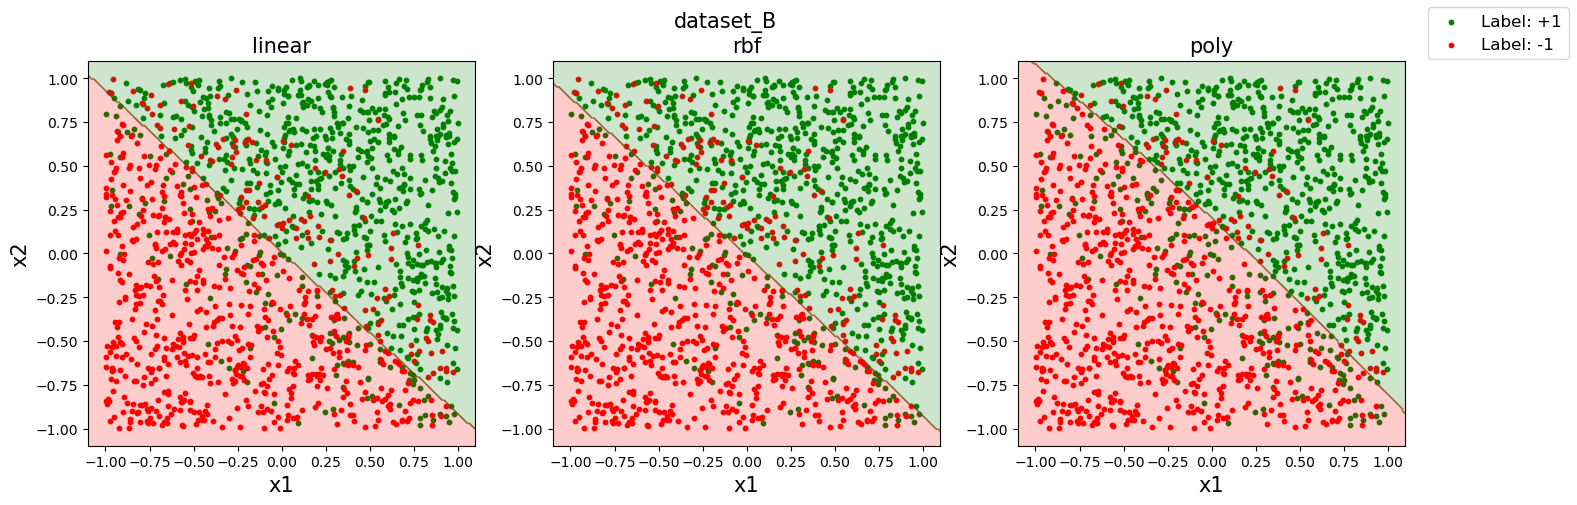

In [7]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

filenames = ['dataset_A', 'dataset_B']
kernels = ['linear', 'rbf', 'poly']
for j,filename in enumerate(filenames):
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    scaler = CustomScaler(np.min(X_train), np.max(X_train))
    X_train = scaler.scale(X_train)
    X_test = scaler.scale(X_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
    line = [0, 0]
    for i,kernel in enumerate(kernels):
        svm_clf = best_svcs[j][i]
        X_train_plus = scaler.rescale(X_train[Y_train==1])
        X_train_minus = scaler.rescale(X_train[Y_train==-1])
        line[0] = ax[i].scatter(X_train_plus[:,0], X_train_plus[:,1], c="green", s=10)
        line[1] = ax[i].scatter(X_train_minus[:,0], X_train_minus[:,1], c="red", s=10)
        x_min, x_max = ax[i].get_xlim()
        y_min, y_max = ax[i].get_ylim()
        X,Y = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
        X_bg = np.transpose(np.array([np.ndarray.flatten(X), np.ndarray.flatten(Y)]))
        X_bg = scaler.scale(X_bg)
        Z = svm_clf.predict(X_bg)
        Z = np.reshape(a=Z, newshape=X.shape, order='C')
        ax[i].contourf(X, Y, Z, colors=["red", "green"], alpha=0.2)
        ax[i].set_xlabel("x1", fontsize=15)
        ax[i].set_ylabel("x2", fontsize=15)
        ax[i].set_title(kernel, fontsize=15)
    plt.suptitle(filename, fontsize=15)
    fig.legend(handles=line, labels=["Label: +1", "Label: -1"], fontsize=12)
    plt.show()


# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [8]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

def get_label(Y):
    if(Y[Y==1].shape[0] >= Y[Y==-1].shape[0]):
        return 1
    else:
        return -1

def get_entropy(p):
    if p == 0 or p == 1:
        return 0
    return (p * np.log2(p) + (1-p) * np.log2(1-p))

def split_entropy(left_pts, left_pos_pts, right_pts, right_pos_pts):
    """
    P_L = left_frac = fraction of points of node going to left node
    q_L = left_pos_frac = fraction of left node points that are positive
    P_R = right_frac = fraction of points of node going to right node
    q_R = right_pos_frac = fraction of right node points that are positive
    
    Entropy of split: P_L * H_L + P_R * H_R
    where H(x) = x * log(1/x) + (1-x) * log(1/1-x)
    H_L = H(q_L), H_R = H(q_R)
    """
    left_frac = left_pts/(left_pts + right_pts)
    right_frac = right_pts/(left_pts + right_pts)
    left_pos_frac = 0
    right_pos_frac = 0
    if left_pts > 0:
        left_pos_frac = left_pos_pts/left_pts
    if right_pts > 0:
        right_pos_frac = right_pos_pts/right_pts
    left_contribution = -1 * left_frac * get_entropy(left_pos_frac)
    right_contribution = -1 * right_frac * get_entropy(right_pos_frac)
    return left_contribution + right_contribution

def split_accuracy(left_pts, left_pos_pts, right_pts, right_pos_pts):
    left_correct = np.max([left_pos_pts, left_pts-left_pos_pts])
    right_correct = np.max([right_pos_pts, right_pts-right_pos_pts])
    return (left_correct + right_correct)/(left_pts + right_pts)


class Node:
    """
    Members:
    depth: int, depth of node in tree (root being 0)
    split_feature: int, the feature index that is used to make decision
    threshold: float, the decision threshold
    left: node, left child of the current node
    right: node, right child of the current node
        left child -> subset of self such that x_(split_feature) <= threshold is true
        right child -> subset of self such that x_(split_feature) <= threshold is false
    is_leaf: boolean, whether or not the node is a leaf node
    label: any, categorical label to be given to node (valid only for leaf nodes)
    """
    def __init__(self, depth):
        self.depth = depth

    def make_split(self, split_feature, threshold):
        self.split_feature = split_feature
        self.threshold = threshold

    def make_children(self):
        self.left = Node(self.depth + 1)
        self.right = Node(self.depth + 1)
        self.is_leaf = False

    def classify_leaf(self, label):
        self.is_leaf = True
        self.label = label

    def split_node(self, X, Y, num_nodes_stop, criterion):
        if np.size(np.unique(Y)) == 1:
            self.classify_leaf(Y[0])
            return
        elif np.size(Y) <= num_nodes_stop:
            self.classify_leaf(get_label(Y))
            return
        
        best_split_feature = 0
        best_threshold = np.min(X[:,0])
        max_accuracy = 0
        min_entropy = np.inf
        for i in range(X.shape[1]): #number of features
            choices = np.unique(X[:,i])
            left_pts = 0
            right_pts = X.shape[0]
            left_pos_pts = 0
            right_pos_pts = np.size(Y[Y==1])
            next_index = 0

            X_sort = X[X[:,i].argsort()]
            Y_sort = Y[X[:,i].argsort()]
            # Find the best split possible
            for choice in choices:
                while (next_index < X.shape[0] and X_sort[next_index, i] == choice):
                    left_pts = left_pts + 1
                    right_pts = right_pts - 1
                    if Y_sort[next_index] == 1:
                        left_pos_pts = left_pos_pts + 1
                        right_pos_pts = right_pos_pts -1
                    next_index = next_index + 1
                if criterion == 'accuracy':
                    curr_accuracy = split_accuracy(left_pts, left_pos_pts, right_pts, right_pos_pts)
                    if curr_accuracy > max_accuracy:
                        best_split_feature = i
                        best_threshold = choice
                        max_accuracy = curr_accuracy
                elif criterion == 'entropy':
                    curr_entropy = split_entropy(left_pts, left_pos_pts, right_pts, right_pos_pts)
                    if curr_entropy < min_entropy:
                        best_split_feature = i
                        best_threshold = choice
                        min_entropy = curr_entropy
                
        # Perform the split, make children and split them further
        self.make_split(best_split_feature, best_threshold)
        self.make_children()
        X_left = np.array(list(x for x in X if x[best_split_feature] <= best_threshold))
        Y_left = np.array(list(Y[i] for i,x in enumerate(X) if x[best_split_feature] <= best_threshold))
        X_right = np.array(list(x for x in X if x[best_split_feature] > best_threshold))
        Y_right = np.array(list(Y[i] for i,x in enumerate(X) if x[best_split_feature] > best_threshold))
        if Y_left.shape == Y.shape or Y_right.shape == Y.shape:
            self.classify_leaf(get_label(Y))
            return
        self.left.split_node(X_left, Y_left, num_nodes_stop, criterion)
        self.right.split_node(X_right, Y_right, num_nodes_stop, criterion)

        

    def get_decision(self, x_test):
        if self.is_leaf:
            return self.label
        else:
            if x_test[self.split_feature] <= self.threshold:
                return self.left.get_decision(x_test)
            else:
                return self.right.get_decision(x_test)



def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(0)
    root.split_node(X, Y, num_nodes_stop, criterion)
    return root



def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    return np.array(list(tree.get_decision(x) for x in test_X))


In [9]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

# RUNS FOR ABOUT 10 MINUTES

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)

def cross_validate(X, Y, criterion):
    n = Y.shape[0]
    X_train = X[:int(0.8*n)]
    Y_train = Y[:int(0.8*n)]
    X_val = X[int(0.8*n):]
    Y_val = Y[int(0.8*n):]
    hyperparams = np.array(range(1, 41))
    accuracies = np.zeros(hyperparams.shape)
    for i,hyperparam in enumerate(hyperparams):
        trained_tree = train_decision_tree(X_train, Y_train, hyperparam, criterion)
        accuracies[i] = accuracy_score(Y_val, eval_decision_tree(trained_tree, X_val))
    best_hyperparam = hyperparams[np.argmax(accuracies)]
    return best_hyperparam

filenames = ['dataset_A', 'dataset_B', 'dataset_C', 'dataset_D']
best_trees = np.zeros((4,2)).tolist()
for i,filename in enumerate(filenames):
    print(filename)
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    criteria = ['accuracy', 'entropy']
    for j,criterion in enumerate(criteria):
        best_hyperparam = cross_validate(X_train, Y_train, criterion)
        print("Best min node size: " + str(best_hyperparam))
        tree = train_decision_tree(X_train, Y_train, best_hyperparam, criterion)
        best_trees[i][j] = tree
        train_error = 1 - accuracy_score(Y_train, eval_decision_tree(tree, X_train))
        print("Train zero-one error: " + str(train_error))
        test_error = 1 - accuracy_score(Y_test, eval_decision_tree(tree, X_test))
        print("Test zero-one error: " + str(test_error))

dataset_A
Best min node size: 1
Train zero-one error: 0.0
Test zero-one error: 0.07599999999999996
Best min node size: 1
Train zero-one error: 0.0
Test zero-one error: 0.010000000000000009
dataset_B
Best min node size: 22
Train zero-one error: 0.062000000000000055
Test zero-one error: 0.28
Best min node size: 28
Train zero-one error: 0.10533333333333328
Test zero-one error: 0.22799999999999998
dataset_C
Best min node size: 32
Train zero-one error: 0.07733333333333337
Test zero-one error: 0.16161616161616166
Best min node size: 5
Train zero-one error: 0.00666666666666671
Test zero-one error: 0.11111111111111116
dataset_D
Best min node size: 5
Train zero-one error: 0.012499999999999956
Test zero-one error: 0.10650887573964496
Best min node size: 1
Train zero-one error: 0.0
Test zero-one error: 0.09467455621301779


TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

### Observations:

Chosen hyperparameter possibilities for num_nodes_stop: [1, 2, 3, ..., 40]

Accuracy has better results than entropy, due to its picking better splits, whereas accuracy could pick a split which ends up leading to overfitting later. Dataset C and D seem to have been overfit, especially with entropy, probably due to a larger number of datapoints/number of features ration. Dataset A is well-fit, reaching 0 train error due to easy separability. Dataset B also appears to be a case of overfitting, with the tree trying to classify more points correctly leading to non-trivial splits. But the hyperparameter is reasonably large, so it does not completely fall prey to overfitting.

### Cross-validation information:

#### dataset_A

| Criterion\Info  | Best num_nodes_stop | Train error | Test error |
| :-------------: | :-----------------: | :---------: | :--------: |
| <b>Accuracy</b> | 1                   | 0           | 0.076      |
| <b>Entropy</b>  | 1                   | 0           | 0.01       |

#### dataset_B

| Criterion\Info  | Best num_nodes_stop | Train error | Test error |
| :-------------: | :-----------------: | :---------: | :--------: |
| <b>Accuracy</b> | 22                  | 0.062       | 0.28       |
| <b>Entropy</b>  | 28                  | 0.105333    | 0.228      |

#### dataset_C

| Criterion\Info  | Best num_nodes_stop | Train error | Test error |
| :-------------: | :-----------------: | :---------: | :--------: |
| <b>Accuracy</b> | 32                  | 0.077333    | 0.161616   |
| <b>Entropy</b>  | 5                   | 0.006667    | 0.111111   |

#### dataset_D

| Criterion\Info  | Best num_nodes_stop | Train error | Test error |
| :-------------: | :-----------------: | :---------: | :--------: |
| <b>Accuracy</b> | 5                   | 0.0125      | 0.106509   |
| <b>Entropy</b>  | 1                   | 0           | 0.094675   |

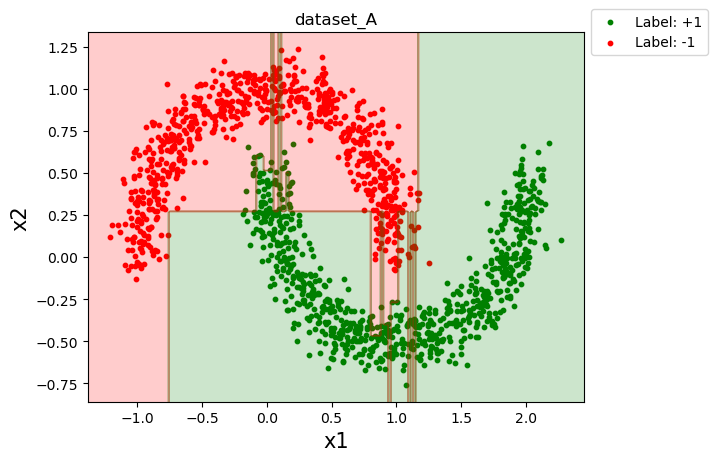

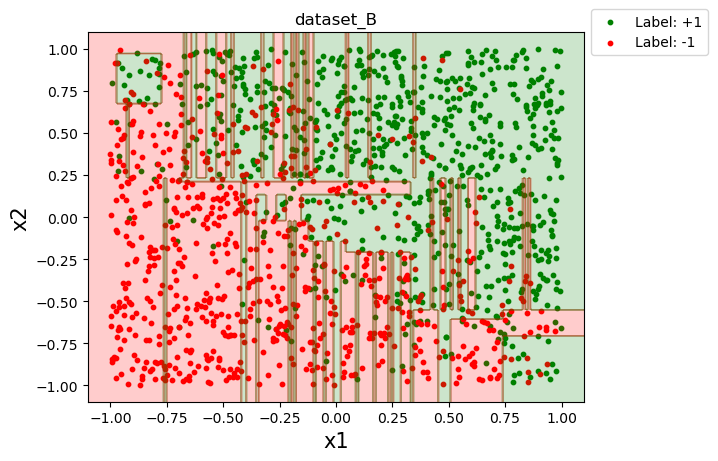

In [10]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

filenames = ['dataset_A', 'dataset_B']
for j,filename in enumerate(filenames):
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    line = [0, 0]
    tree = best_trees[j][0]
    X_train_plus = X_train[Y_train==1]
    X_train_minus = X_train[Y_train==-1]
    line[0] = plt.scatter(X_train_plus[:,0], X_train_plus[:,1], c="green", s=10)
    line[1] = plt.scatter(X_train_minus[:,0], X_train_minus[:,1], c="red", s=10)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    X,Y = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
    X_bg = np.transpose(np.array([np.ndarray.flatten(X), np.ndarray.flatten(Y)]))
    Z = eval_decision_tree(tree, X_bg)
    Z = np.reshape(a=Z, newshape=X.shape, order='C')
    plt.contourf(X, Y, Z, colors=["red", "green"], alpha=0.2)
    plt.xlabel("x1", fontsize=15)
    plt.ylabel("x2", fontsize=15)
    plt.title(filename)
    plt.legend(handles=line, labels=["Label: +1", "Label: -1"], fontsize=10, loc='center left', bbox_to_anchor=(1, 1))
    plt.show()


# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [11]:
# CodeWrite cell
# Write Random Forest classifier. 

def get_label(Y):
    if(Y[Y==1].shape[0] >= Y[Y==-1].shape[0]):
        return 1
    else:
        return -1

def get_entropy(p):
    if p == 0 or p == 1:
        return 0
    return (p * np.log2(p) + (1-p) * np.log2(1-p))

def split_entropy(left_pts, left_pos_pts, right_pts, right_pos_pts):
    """
    P_L = left_frac = fraction of points of node going to left node
    q_L = left_pos_frac = fraction of left node points that are positive
    P_R = right_frac = fraction of points of node going to right node
    q_R = right_pos_frac = fraction of right node points that are positive
    
    Entropy of split: P_L * H_L + P_R * H_R
    where H(x) = x * log(1/x) + (1-x) * log(1/1-x)
    H_L = H(q_L), H_R = H(q_R)
    """
    left_frac = left_pts/(left_pts + right_pts)
    right_frac = right_pts/(left_pts + right_pts)
    left_pos_frac = 0
    right_pos_frac = 0
    if left_pts > 0:
        left_pos_frac = left_pos_pts/left_pts
    if right_pts > 0:
        right_pos_frac = right_pos_pts/right_pts
    left_contribution = -1 * left_frac * get_entropy(left_pos_frac)
    right_contribution = -1 * right_frac * get_entropy(right_pos_frac)
    return left_contribution + right_contribution

def split_accuracy(left_pts, left_pos_pts, right_pts, right_pos_pts):
    left_correct = np.max([left_pos_pts, left_pts-left_pos_pts])
    right_correct = np.max([right_pos_pts, right_pts-right_pos_pts])
    return (left_correct + right_correct)/(left_pts + right_pts)


class Node:
    """
    Members:
    depth: int, depth of node in tree (root being 0)
    split_feature: int, the feature index that is used to make decision
    threshold: float, the decision threshold
    left: node, left child of the current node
    right: node, right child of the current node
        left child -> subset of self such that x_(split_feature) <= threshold is true
        right child -> subset of self such that x_(split_feature) <= threshold is false
    is_leaf: boolean, whether or not the node is a leaf node
    label: any, categorical label to be given to node (valid only for leaf nodes)
    """
    def __init__(self, depth):
        self.depth = depth

    def make_split(self, split_feature, threshold):
        self.split_feature = split_feature
        self.threshold = threshold

    def make_children(self):
        self.left = Node(self.depth + 1)
        self.right = Node(self.depth + 1)
        self.is_leaf = False

    def classify_leaf(self, label):
        self.is_leaf = True
        self.label = label

    def split_node(self, X, Y, b, num_nodes_stop, criterion):
        if np.size(np.unique(Y)) == 1:
            self.classify_leaf(Y[0])
            return
        elif np.size(Y) <= num_nodes_stop:
            self.classify_leaf(get_label(Y))
            return
        
        best_split_feature = 0
        best_threshold = np.min(X[:,0])
        max_accuracy = 0
        min_entropy = np.inf
        rng = np.random.default_rng()
        random_features = rng.permutation(X.shape[1])[:int(b*X.shape[1])]
        for i in random_features:
            choices = np.unique(X[:,i])
            left_pts = 0
            right_pts = X.shape[0]
            left_pos_pts = 0
            right_pos_pts = np.size(Y[Y==1])
            next_index = 0

            X_sort = X[X[:,i].argsort()]
            Y_sort = Y[X[:,i].argsort()]
            for choice in choices:
                while (next_index < X.shape[0] and X_sort[next_index, i] == choice):
                    left_pts = left_pts + 1
                    right_pts = right_pts - 1
                    if Y_sort[next_index] == 1:
                        left_pos_pts = left_pos_pts + 1
                        right_pos_pts = right_pos_pts -1
                    next_index = next_index + 1
                if criterion == 'accuracy':
                    curr_accuracy = split_accuracy(left_pts, left_pos_pts, right_pts, right_pos_pts)
                    if curr_accuracy > max_accuracy:
                        best_split_feature = i
                        best_threshold = choice
                        max_accuracy = curr_accuracy
                elif criterion == 'entropy':
                    curr_entropy = split_entropy(left_pts, left_pos_pts, right_pts, right_pos_pts)
                    if curr_entropy < min_entropy:
                        best_split_feature = i
                        best_threshold = choice
                        min_entropy = curr_entropy
                
        self.make_split(best_split_feature, best_threshold)
        self.make_children()
        X_left = np.array(list(x for x in X if x[best_split_feature] <= best_threshold))
        Y_left = np.array(list(Y[i] for i,x in enumerate(X) if x[best_split_feature] <= best_threshold))
        X_right = np.array(list(x for x in X if x[best_split_feature] > best_threshold))
        Y_right = np.array(list(Y[i] for i,x in enumerate(X) if x[best_split_feature] > best_threshold))
        if Y_left.shape == Y.shape or Y_right.shape == Y.shape:
            self.classify_leaf(get_label(Y))
            return
        self.left.split_node(X_left, Y_left, b, num_nodes_stop, criterion)
        self.right.split_node(X_right, Y_right, b, num_nodes_stop, criterion)

    def get_decision(self, x_test):
        if self.is_leaf:
            return self.label
        else:
            if x_test[self.split_feature] <= self.threshold:
                return self.left.get_decision(x_test)
            else:
                return self.right.get_decision(x_test)



def train_decision_tree(X, Y, b, num_nodes_stop=1, criterion='accuracy'):
    """ Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(0)
    root.split_node(X, Y, b, num_nodes_stop, criterion)
    return root



def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    return np.array(list(tree.get_decision(x) for x in test_X))



class RandomForest:
    def __init__(self, n_est):
        self.n_est = n_est
        self.estimators = []
    
    def add_estimator(self, tree):
        self.estimators.append(tree)

    def get_decision(self, x_test):
        pred = np.sum(np.array(list(tree.get_decision(x_test) for tree in self.estimators)))
        if pred >= 0:
            return 1
        return -1
    

def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    rf_clf = RandomForest(num_trees)
    for i in range(num_trees):
        X_train = []
        Y_train = []
        for j in range(int(a*Y.shape[0])):
            index = np.random.randint(0, Y.shape[0])
            X_train.append(X[index])
            Y_train.append(Y[index])
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        rf_clf.add_estimator(train_decision_tree(X_train, Y_train, b, num_nodes_stop, criterion))
    return rf_clf
    

def eval_random_forest(random_forest, test_X):
    """ Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    return np.array(list(random_forest.get_decision(test_x) for test_x in test_X))


In [12]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

# RUNS FOR ABOUT 22 MINUTES

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)

def cross_validate(X, Y, criterion):
    n = Y.shape[0]
    X_train = X[:int(0.8*n)]
    Y_train = Y[:int(0.8*n)]
    X_val = X[int(0.8*n):]
    Y_val = Y[int(0.8*n):]
    hyperparams = np.array([10, 50, 100, 200, 500])
    accuracies = np.zeros(hyperparams.shape)
    for i,hyperparam in enumerate(hyperparams):
        rf_clf = train_random_forest(X_train, Y_train, num_trees=hyperparam, criterion=criterion)
        accuracies[i] = accuracy_score(Y_val, eval_random_forest(rf_clf, X_val))
    best_hyperparam = hyperparams[np.argmax(accuracies)]
    return best_hyperparam

filenames = ['dataset_A', 'dataset_B', 'dataset_C', 'dataset_D']
best_rfs = np.zeros((4,2)).tolist()
for i,filename in enumerate(filenames):
    print(filename)
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    criteria = ['accuracy', 'entropy']
    for j,criterion in enumerate(criteria):
        print("Criterion: " + criterion)
        best_hyperparam = cross_validate(X_train, Y_train, criterion)
        print("Best number of trees: " + str(best_hyperparam))
        rf_clf = train_random_forest(X_train, Y_train, num_trees=best_hyperparam, criterion=criterion)
        best_rfs[i][j] = rf_clf
        train_error = 1 - accuracy_score(Y_train, eval_random_forest(rf_clf, X_train))
        print("Train zero-one error: " + str(train_error))
        test_error = 1 - accuracy_score(Y_test, eval_random_forest(rf_clf, X_test))
        print("Test zero-one error: " + str(test_error))

dataset_A
Criterion: accuracy
Best number of trees: 100
Train zero-one error: 0.009333333333333305
Test zero-one error: 0.03200000000000003
Criterion: entropy
Best number of trees: 10
Train zero-one error: 0.0033333333333332993
Test zero-one error: 0.010000000000000009
dataset_B
Criterion: accuracy
Best number of trees: 100
Train zero-one error: 0.04933333333333334
Test zero-one error: 0.21199999999999997
Criterion: entropy
Best number of trees: 50
Train zero-one error: 0.05133333333333334
Test zero-one error: 0.20599999999999996
dataset_C
Criterion: accuracy
Best number of trees: 200
Train zero-one error: 0.019333333333333313
Test zero-one error: 0.06397306397306401
Criterion: entropy
Best number of trees: 50
Train zero-one error: 0.0020000000000000018
Test zero-one error: 0.06397306397306401
dataset_D
Criterion: accuracy
Best number of trees: 10
Train zero-one error: 0.020000000000000018
Test zero-one error: 0.059171597633136064
Criterion: entropy
Best number of trees: 100
Train zero

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

### Observations:

Chosen range of hyperparameters: [10, 50, 100, 200, 500]

Right off the bat, improvement over plain decision trees is visible, especially in datasets C and D, where the error has roughly halved. Dataset B has similar performance, dataset A shows some improvement with metric as accuracy. One notable result is that no dataset has been fit with 500 trees, so there appears to be no significant gain in performance beyond a certain number of trees. As always, dataset A is well fit while dataset B is not. Datasets C and D are also well fit here, with accuracies of close to 95%. There is no clear winner between accuracy and entropy here, but accuracy does not significantly outperform entropy.

### Cross-validation information:

#### dataset_A

| Criterion\Info  | Best number of trees | Train error | Test error |
| :-------------: | :------------------: | :---------: | :--------: |
| <b>Accuracy</b> | 100                  | 0.009333    | 0.032      |
| <b>Entropy</b>  | 10                   | 0.003333    | 0.01       |

#### dataset_B

| Criterion\Info  | Best number of trees | Train error | Test error |
| :-------------: | :------------------: | :---------: | :--------: |
| <b>Accuracy</b> | 100                  | 0.049333    | 0.212      |
| <b>Entropy</b>  | 50                   | 0.051333    | 0.206      |

#### dataset_C

| Criterion\Info  | Best number of trees | Train error | Test error |
| :-------------: | :------------------: | :---------: | :--------: |
| <b>Accuracy</b> | 200                  | 0.019333    | 0.063973   |
| <b>Entropy</b>  | 50                   | 0.002       | 0.063973   |

#### dataset_D

| Criterion\Info  | Best number of trees | Train error | Test error |
| :-------------: | :------------------: | :---------: | :--------: |
| <b>Accuracy</b> | 10                   | 0.02        | 0.059172   |
| <b>Entropy</b>  | 100                  | 0.0075      | 0.053254   |

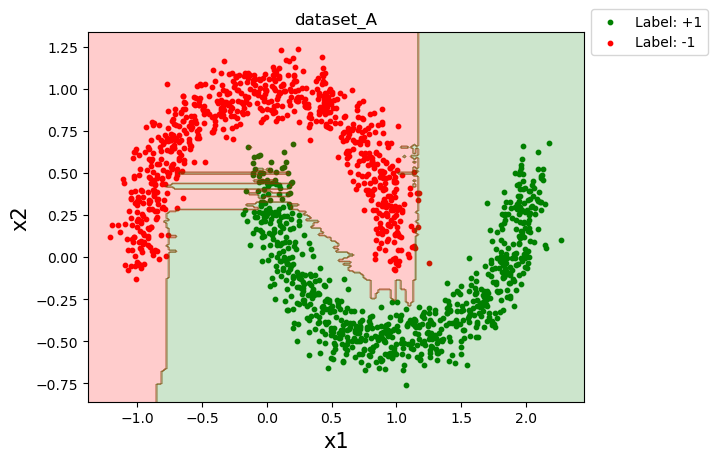

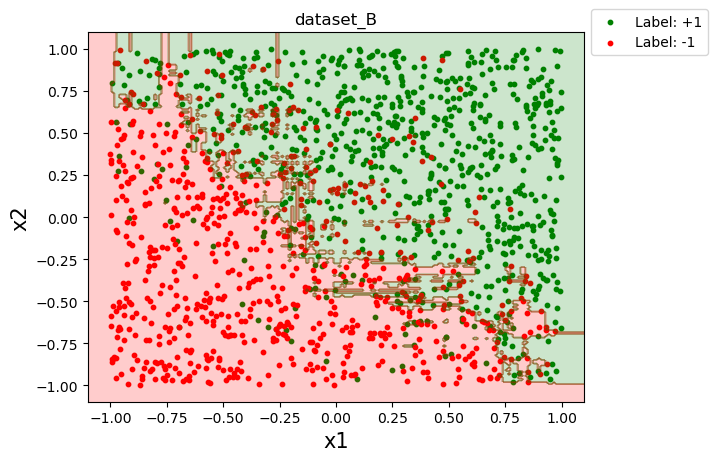

In [13]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

# RUNS FOR ABOUT 3 MINUTES

filenames = ['dataset_A', 'dataset_B']
for j,filename in enumerate(filenames):
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    line = [0, 0]
    rf_clf = best_rfs[j][0]
    X_train_plus = X_train[Y_train==1]
    X_train_minus = X_train[Y_train==-1]
    line[0] = plt.scatter(X_train_plus[:,0], X_train_plus[:,1], c="green", s=10)
    line[1] = plt.scatter(X_train_minus[:,0], X_train_minus[:,1], c="red", s=10)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    X,Y = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
    X_bg = np.transpose(np.array([np.ndarray.flatten(X), np.ndarray.flatten(Y)]))
    Z = eval_random_forest(rf_clf, X_bg)
    Z = np.reshape(a=Z, newshape=X.shape, order='C')
    plt.contourf(X, Y, Z, colors=["red", "green"], alpha=0.2)
    plt.xlabel("x1", fontsize=15)
    plt.ylabel("x2", fontsize=15)
    plt.title(filename)
    plt.legend(handles=line, labels=["Label: +1", "Label: -1"], fontsize=10, loc='center left', bbox_to_anchor=(1, 1))
    plt.show()

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [14]:
# Codewrite cell
# Write code to run here (no plotting)

# RUNS FOR ABOUT 3 MINUTES

def get_label(Y, w):
    if(np.sum(w[Y==1]) >= np.sum(w[Y==-1])):
        return 1
    else:
        return -1

def get_entropy(p):
    if p == 0 or p == 1:
        return 0
    return (p * np.log2(p) + (1-p) * np.log2(1-p))

def split_entropy(left_pts, left_pos_pts, right_pts, right_pos_pts):
    """
    P_L = left_frac = fraction of points of node going to left node
    q_L = left_pos_frac = fraction of left node points that are positive
    P_R = right_frac = fraction of points of node going to right node
    q_R = right_pos_frac = fraction of right node points that are positive
    
    Entropy of split: P_L * H_L + P_R * H_R
    where H(x) = x * log(1/x) + (1-x) * log(1/1-x)
    H_L = H(q_L), H_R = H(q_R)
    """
    left_frac = left_pts/(left_pts + right_pts)
    right_frac = right_pts/(left_pts + right_pts)
    left_pos_frac = 0
    right_pos_frac = 0
    if left_pts > 0:
        left_pos_frac = left_pos_pts/left_pts
    if right_pts > 0:
        right_pos_frac = right_pos_pts/right_pts
    left_contribution = -1 * left_frac * get_entropy(left_pos_frac)
    right_contribution = -1 * right_frac * get_entropy(right_pos_frac)
    return left_contribution + right_contribution

def split_accuracy(left_pts, left_pos_pts, right_pts, right_pos_pts):
    left_correct = np.max([left_pos_pts, left_pts-left_pos_pts])
    right_correct = np.max([right_pos_pts, right_pts-right_pos_pts])
    return (left_correct + right_correct)/(left_pts + right_pts)

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)


class Node:
    """
    Members:
    depth: int, depth of node in tree (root being 0)
    split_feature: int, the feature index that is used to make decision
    threshold: float, the decision threshold
    left: node, left child of the current node
    right: node, right child of the current node
        left child -> subset of self such that x_(split_feature) <= threshold is true
        right child -> subset of self such that x_(split_feature) <= threshold is false
    is_leaf: boolean, whether or not the node is a leaf node
    label: any, categorical label to be given to node (valid only for leaf nodes)
    """
    def __init__(self, depth):
        self.depth = depth

    def make_split(self, split_feature, threshold):
        self.split_feature = split_feature
        self.threshold = threshold

    def make_children(self):
        self.left = Node(self.depth + 1)
        self.right = Node(self.depth + 1)
        self.is_leaf = False

    def classify_leaf(self, label):
        self.is_leaf = True
        self.label = label

    def split_node(self, X, Y, w, max_depth, num_nodes_stop, criterion):
        if np.size(np.unique(Y)) == 1:
            self.classify_leaf(Y[0])
            return
        elif np.size(Y) <= num_nodes_stop:
            self.classify_leaf(get_label(Y, w))
            return
        elif self.depth == max_depth:
            self.classify_leaf(get_label(Y, w))
            return
        
        best_split_feature = 0
        best_threshold = np.min(X[:,0])
        max_accuracy = 0
        min_entropy = np.inf
        for i in range(X.shape[1]): 
            choices = np.unique(X[:,i])
            left_pts = 0
            right_pts = np.sum(w)
            left_pos_pts = 0
            right_pos_pts = np.sum(w[Y==1])
            next_index = 0

            X_sort = X[X[:,i].argsort()]
            Y_sort = Y[X[:,i].argsort()]
            w_sort = w[X[:,i].argsort()]
            for choice in choices:
                while (next_index < X.shape[0] and X_sort[next_index, i] == choice):
                    left_pts = left_pts + w_sort[next_index]
                    right_pts = right_pts - w_sort[next_index]
                    if Y_sort[next_index] == 1:
                        left_pos_pts = left_pos_pts + w_sort[next_index]
                        right_pos_pts = right_pos_pts -w_sort[next_index]
                    next_index = next_index + 1
                if criterion == 'accuracy':
                    curr_accuracy = split_accuracy(left_pts, left_pos_pts, right_pts, right_pos_pts)
                    if curr_accuracy > max_accuracy:
                        best_split_feature = i
                        best_threshold = choice
                        max_accuracy = curr_accuracy
                elif criterion == 'entropy':
                    curr_entropy = split_entropy(left_pts, left_pos_pts, right_pts, right_pos_pts)
                    if curr_entropy < min_entropy:
                        best_split_feature = i
                        best_threshold = choice
                        min_entropy = curr_entropy
                
        self.make_split(best_split_feature, best_threshold)
        self.make_children()
        X_left = np.array(list(x for x in X if x[best_split_feature] <= best_threshold))
        Y_left = np.array(list(Y[i] for i,x in enumerate(X) if x[best_split_feature] <= best_threshold))
        w_left = np.array(list(w[i] for i,x in enumerate(X) if x[best_split_feature] <= best_threshold))
        X_right = np.array(list(x for x in X if x[best_split_feature] > best_threshold))
        Y_right = np.array(list(Y[i] for i,x in enumerate(X) if x[best_split_feature] > best_threshold))
        w_right = np.array(list(w[i] for i,x in enumerate(X) if x[best_split_feature] > best_threshold))
        if Y_left.shape == Y.shape or Y_right.shape == Y.shape:
            self.classify_leaf(get_label(Y, w))
            return
        self.left.split_node(X_left, Y_left, w_left, max_depth, num_nodes_stop, criterion)
        self.right.split_node(X_right, Y_right, w_right, max_depth, num_nodes_stop, criterion)

        

    def get_decision(self, x_test):
        if self.is_leaf:
            return self.label
        else:
            if x_test[self.split_feature] <= self.threshold:
                return self.left.get_decision(x_test)
            else:
                return self.right.get_decision(x_test)


def train_decision_tree(X, Y, w, max_depth, num_nodes_stop=1, criterion='accuracy'):
    """ Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(0)
    root.split_node(X, Y, w, max_depth, num_nodes_stop, criterion)
    return root



def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    return np.array(list(tree.get_decision(x) for x in test_X))



def train_weak_learner(X, Y, w, max_depth):
    return train_decision_tree(X, Y, w, max_depth, num_nodes_stop=0.05*np.size(Y))

class AdaBoostClassifier:
    def __init__(self, num_iterations):
        self.num_iterations = num_iterations
        self.weak_learners = []
        self.betas = []
        self.train_errors = []
        self.test_errors = []
    
    def add_iteration(self, weak_learner, beta):
        self.weak_learners.append(weak_learner)
        self.betas.append(beta)
    
    def get_prediction(self, test_x):
        pred = np.sum(np.array(list(np.log(self.betas[i]) * self.weak_learners[i].get_decision(test_x) for i in range(np.size(self.betas)))))
        if pred >= 0:
            return 1
        return -1
    
    def add_errors(self, train_error, test_error):
        self.train_errors.append(train_error)
        self.test_errors.append(test_error)
    

def eval_AdaBoost_classifier(AdaBoost_clf, test_X):
    return np.array(list(AdaBoost_clf.get_prediction(test_x) for test_x in test_X))

def train_AdaBoost_classifier(X_train, Y_train, X_test, Y_test, weak_learner_choice, num_iterations=50):
    w = np.ones(Y_train.shape)
    AdaBoost_clf = AdaBoostClassifier(num_iterations)
    for i in range(num_iterations):
        weak_learner = train_weak_learner(X_train, Y_train, w, weak_learner_choice)
        l = np.array(list(np.abs(weak_learner.get_decision(X_train[j]) - Y_train[j])/2 for j in range(Y_train.shape[0])))
        gamma = 0.5 - np.sum(w * l)/np.sum(w)
        if gamma == 0.5:
            beta = np.inf
        else:
            beta = (0.5 + gamma)/(0.5 - gamma)
            w = w * (beta ** l)
        AdaBoost_clf.add_iteration(weak_learner, beta)
        train_error = 1 - accuracy_score(Y_train, eval_AdaBoost_classifier(AdaBoost_clf, X_train))
        test_error = 1 - accuracy_score(Y_test, eval_AdaBoost_classifier(AdaBoost_clf, X_test))
        AdaBoost_clf.add_errors(train_error, test_error)
    return AdaBoost_clf


filenames = ['dataset_A', 'dataset_B', 'dataset_C', 'dataset_D']
weak_learner_choices = [1, 3, 7]
trained_clfs = np.zeros((4, 3)).tolist()
for i,filename in enumerate(filenames):
    print(filename)
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    for j,weak_learner_choice in enumerate(weak_learner_choices):
        print("Weak learner: Decision tree of depth " + str(weak_learner_choice))
        trained_clf = train_AdaBoost_classifier(X_train, Y_train, X_test, Y_test, weak_learner_choice)
        trained_clfs[i][j] = trained_clf
        print("Train error: " + str(trained_clf.train_errors[-1]))
        print("Test error: " + str(trained_clf.test_errors[-1]))


dataset_A
Weak learner: Decision tree of depth 1
Train error: 0.0
Test error: 0.01200000000000001
Weak learner: Decision tree of depth 3
Train error: 0.0
Test error: 0.014000000000000012
Weak learner: Decision tree of depth 7
Train error: 0.0
Test error: 0.01200000000000001
dataset_B
Weak learner: Decision tree of depth 1
Train error: 0.16733333333333333
Test error: 0.20199999999999996
Weak learner: Decision tree of depth 3
Train error: 0.13
Test error: 0.21999999999999997
Weak learner: Decision tree of depth 7
Train error: 0.03066666666666662
Test error: 0.22799999999999998
dataset_C
Weak learner: Decision tree of depth 1
Train error: 0.04800000000000004
Test error: 0.101010101010101
Weak learner: Decision tree of depth 3
Train error: 0.0
Test error: 0.0505050505050505
Weak learner: Decision tree of depth 7
Train error: 0.0
Test error: 0.0572390572390572
dataset_D
Weak learner: Decision tree of depth 1
Train error: 0.0
Test error: 0.029585798816568087
Weak learner: Decision tree of de

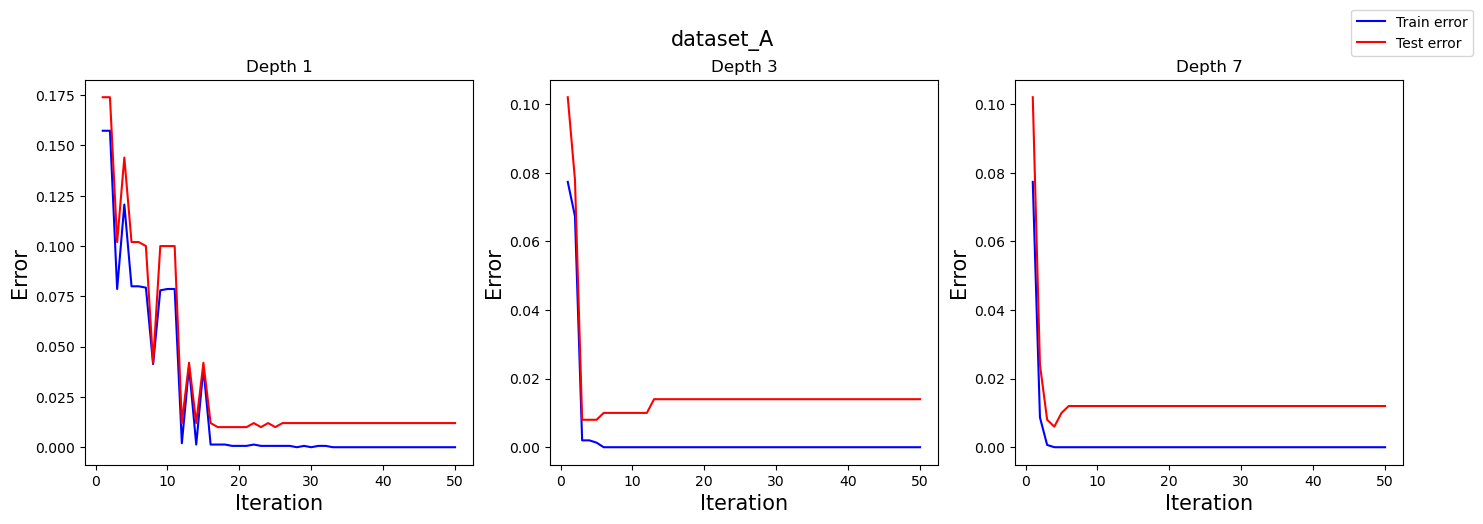

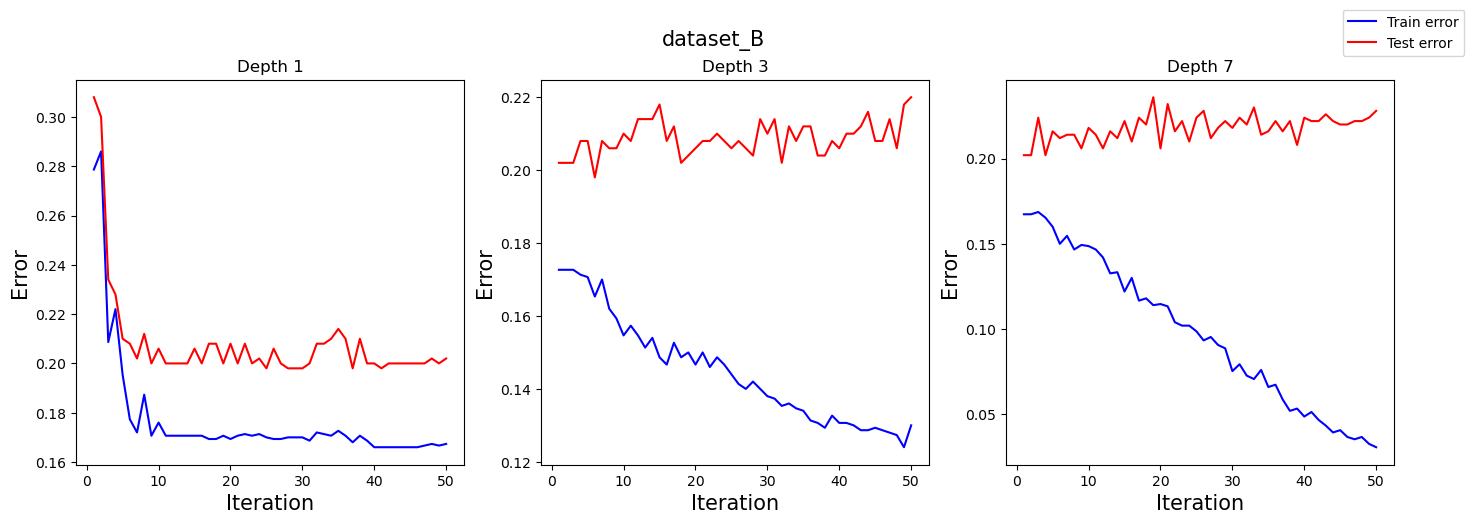

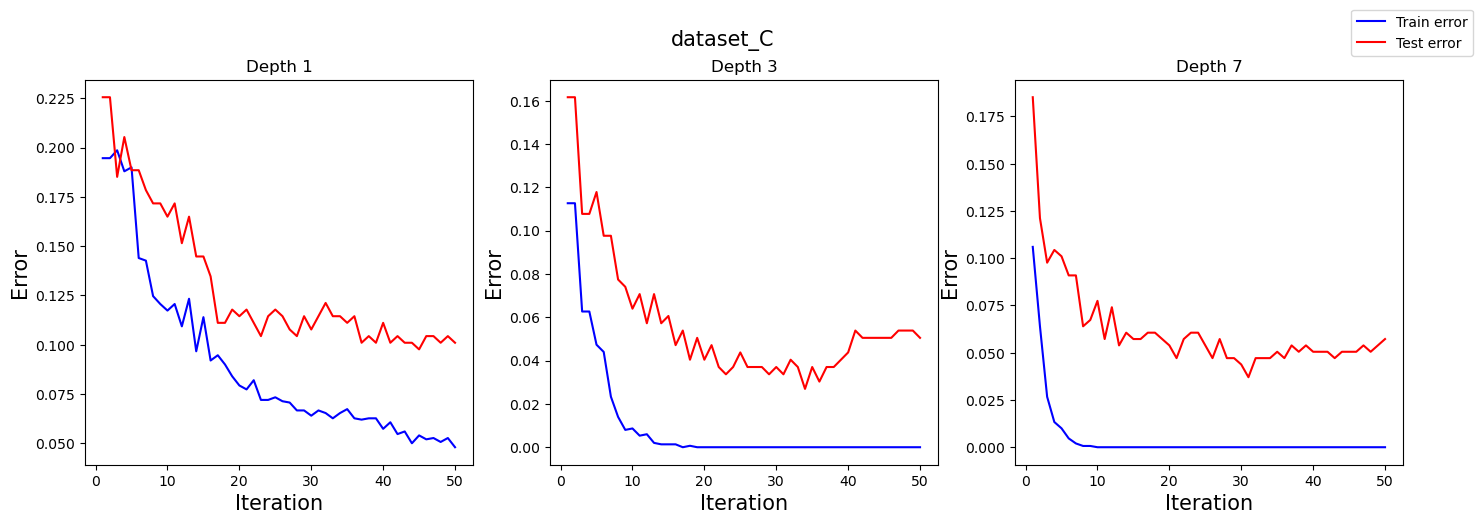

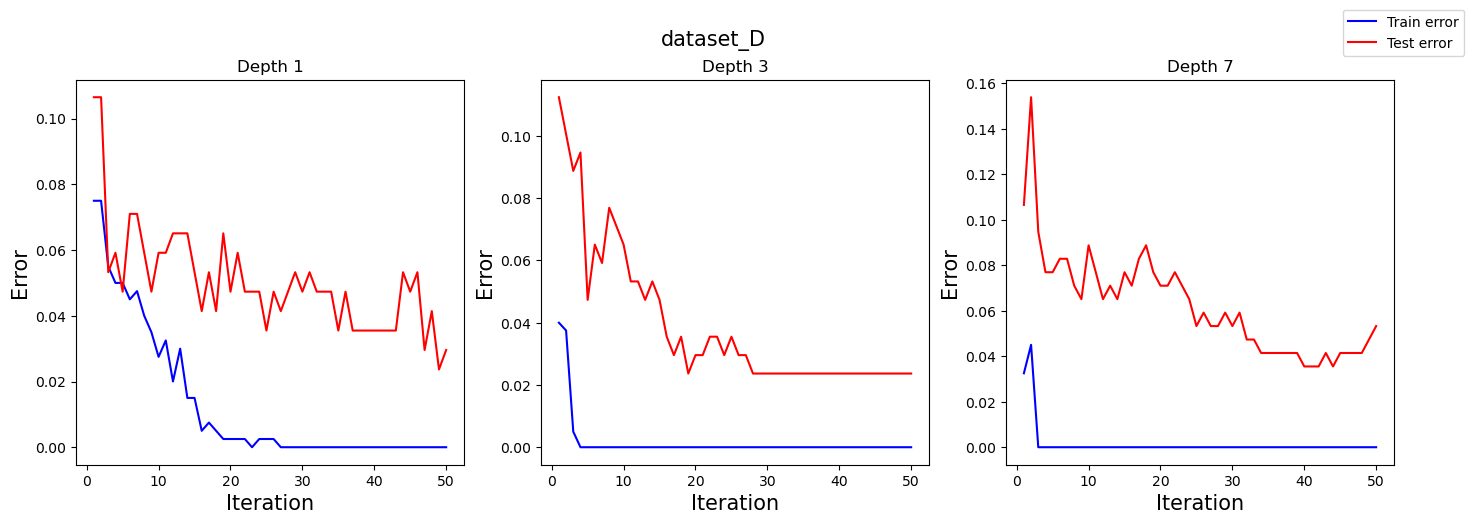

In [15]:
# Codewrite cell 
# Plots for iteration vs error here

for i,filename in enumerate(filenames):
    fig, ax = plt.subplots(1, 3, figsize=(17,5))
    line = [0, 0]
    for j,weak_learner_choice in enumerate(weak_learner_choices):
        AdaBoost_clf = trained_clfs[i][j]
        iterations = np.array(range(1, 51))
        line[0] = ax[j].plot(iterations, AdaBoost_clf.train_errors, c="blue", label="Train error")
        line[1] = ax[j].plot(iterations, AdaBoost_clf.test_errors, c="red", label="Test error")
        ax[j].set_xlabel("Iteration", fontsize=15)
        ax[j].set_ylabel("Error", fontsize=15)
        ax[j].set_title("Depth " + str(weak_learner_choice))
    plt.suptitle(filename, fontsize=15)
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.2))
    plt.show()

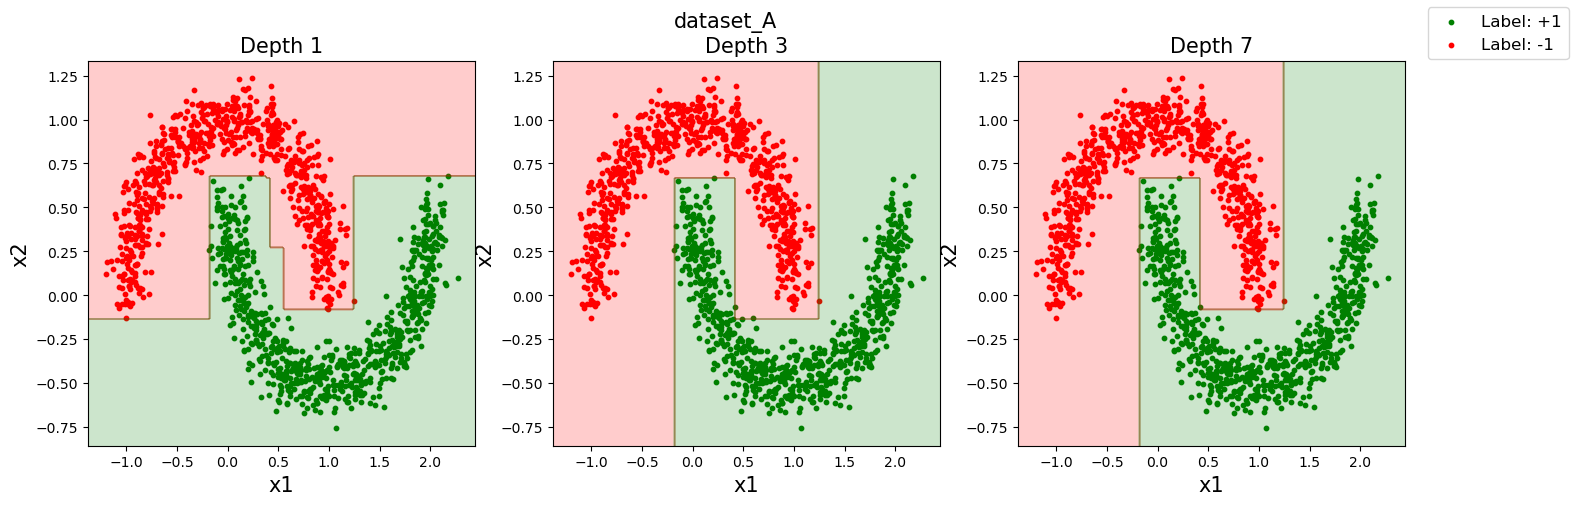

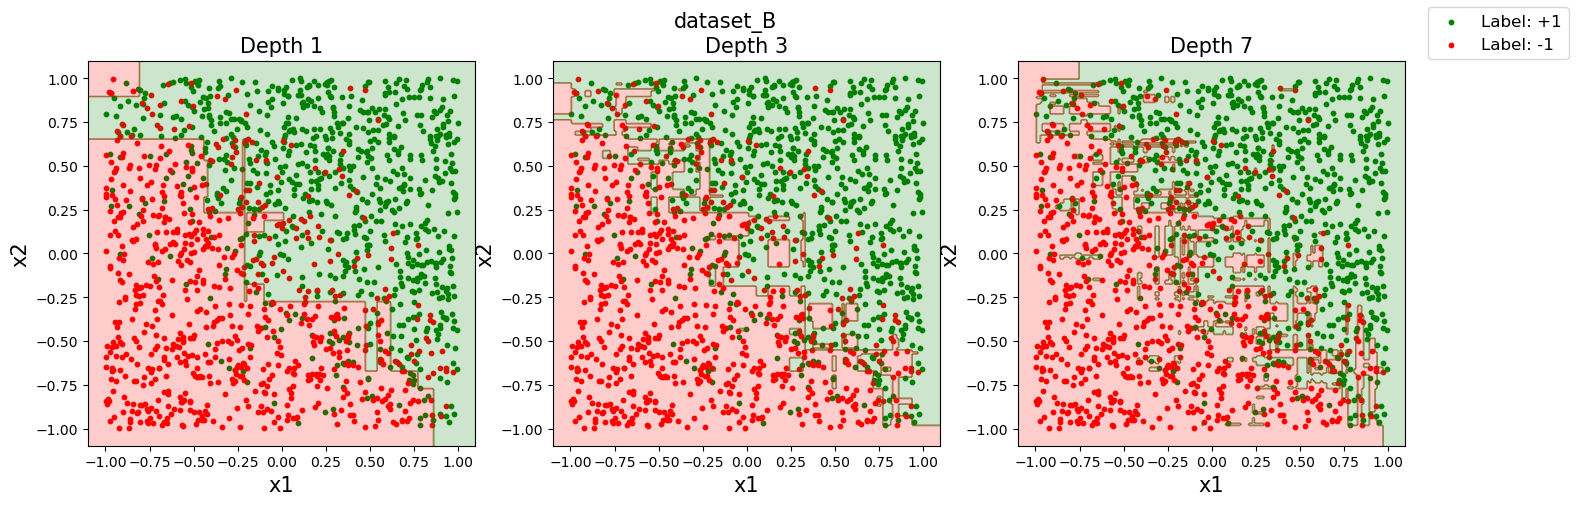

In [16]:
# Codewrite cell 
# Plots for illustrating the classifier here

filenames = ['dataset_A', 'dataset_B']
for j,filename in enumerate(filenames):
    dataset = np.load("../../Data/" + filename + ".npz")
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    fig, ax = plt.subplots(1, 3, figsize=(17,5))
    line = [0, 0]
    for i,weak_learner_choice in enumerate(weak_learner_choices):
        AdaBoost_clf = trained_clfs[j][i]
        X_train_plus = X_train[Y_train==1]
        X_train_minus = X_train[Y_train==-1]
        line[0] = ax[i].scatter(X_train_plus[:,0], X_train_plus[:,1], c="green", s=10)
        line[1] = ax[i].scatter(X_train_minus[:,0], X_train_minus[:,1], c="red", s=10)
        x_min, x_max = ax[i].get_xlim()
        y_min, y_max = ax[i].get_ylim()
        X,Y = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
        X_bg = np.transpose(np.array([np.ndarray.flatten(X), np.ndarray.flatten(Y)]))
        Z = eval_AdaBoost_classifier(AdaBoost_clf, X_bg)
        Z = np.reshape(a=Z, newshape=X.shape, order='C')
        ax[i].contourf(X, Y, Z, colors=["red", "green"], alpha=0.2)
        ax[i].set_xlabel("x1", fontsize=15)
        ax[i].set_ylabel("x2", fontsize=15)
        ax[i].set_title("Depth "+str(weak_learner_choice), fontsize=15)
    plt.suptitle(filename, fontsize=15)
    fig.legend(handles=line, labels=["Label: +1", "Label: -1"], fontsize=12)
    plt.show()

Textwrite cell:

### Observations:

Visible improvement over decision trees is present, with errors in datasets C and D becoming nearly one-third or one-half here. All depths (1, 3, 7) have similar results for datasets A and B, while in dataset C, depth seems to be underperfoming, whereas in dataset D, depth 7 seems to be underperforming. Boosting is a way to prevent underfitting, so an explanation to this could be that dataset C is a pretty complex dataset, which depth 1 seems to be unable to fit, whereas depth 7 is a very simple dataset (which also explains the 0 train error), which depth 7 overfits a little, which boosting can't help with. A lot of zero train errors are visible, due to cross-validation not being performed here. As always, dataset A is fit well and dataset B fit with ~80% accuracy. Datasets C and D have >90% accuracy for the most part, with D being arguably very well-fit. As seen in the error vs iterations plot, both train and test errors decrease for the most part, with some spikes, possibly due to a lot of change in weights suddenly. In dataset B, test error remains roughly constant/increases a little due to possible overfitting.

### Errors:

#### dataset_A

| Depth of decision tree\Errors | Train error | Test error |
| :---------------------------: | :---------: | :--------: |
| <b>1</b>                      | 0           | 0.012      |
| <b>3</b>                      | 0           | 0.014      |
| <b>7</b>                      | 0           | 0.012      |

#### dataset_B

| Depth of decision tree\Errors | Train error | Test error |
| :---------------------------: | :---------: | :--------: |
| <b>1</b>                      | 0.167333    | 0.202      |
| <b>3</b>                      | 0.13        | 0.22       |
| <b>7</b>                      | 0.030667    | 0.228      |

#### dataset_C

| Depth of decision tree\Errors | Train error | Test error |
| :---------------------------: | :---------: | :--------: |
| <b>1</b>                      | 0.048       | 0.10101    |
| <b>3</b>                      | 0           | 0.050505   |
| <b>7</b>                      | 0           | 0.057239   |

#### dataset_D

| Depth of decision tree\Errors | Train error | Test error |
| :---------------------------: | :---------: | :--------: |
| <b>1</b>                      | 0           | 0.029586   |
| <b>3</b>                      | 0           | 0.023669   |
| <b>7</b>                      | 0           | 0.053254   |
